## Analyzing NYC High School Data
###  Guided Project - Dataquest

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. 

- **[SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4):** SAT scores for each high school in New York City
- **[School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt):** Attendance information for each school in New York City
- **[Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3):** Information on class size for each school
- **[AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e):** Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- **[Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a):** The percentage of students who graduated and other outcome information
- **[Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j):** Demographic information for each school
- **[School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8):** Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

Previously, we did perform some analysis and we are going to work with a combined and clean dataframe.

### Reading in data & surveys

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    data[f[:-4]] = pd.read_csv("schools/{0}".format(f))

In [2]:
for d in data:
    print('\n',d)
    print(data[d].info())


 ap_2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   DBN                                   258 non-null    object
 1   SchoolName                            258 non-null    object
 2   AP Test Takers                        258 non-null    object
 3   Total Exams Taken                     258 non-null    object
 4   Number of Exams with scores 3 4 or 5  258 non-null    object
dtypes: object(5)
memory usage: 10.2+ KB
None

 class_size
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CSD                                   27611 non-null  int64  
 1   BOROUGH                               27611 non-nu

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\laura\AppData\Local\Temp\ipykernel_24856\3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


In [4]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DBN         1702 non-null   object 
 1   rr_s        1041 non-null   float64
 2   rr_t        1702 non-null   int64  
 3   rr_p        1702 non-null   int64  
 4   N_s         1036 non-null   float64
 5   N_t         1700 non-null   float64
 6   N_p         1696 non-null   float64
 7   saf_p_11    1696 non-null   float64
 8   com_p_11    1696 non-null   float64
 9   eng_p_11    1696 non-null   float64
 10  aca_p_11    1696 non-null   float64
 11  saf_t_11    1700 non-null   float64
 12  com_t_11    1700 non-null   float64
 13  eng_t_11    1700 non-null   float64
 14  aca_t_11    1700 non-null   float64
 15  saf_s_11    1036 non-null   float64
 16  com_s_11    1036 non-null   float64
 17  eng_s_11    1036 non-null   float64
 18  aca_s_11    1036 non-null   float64
 19  saf_tot_11  1702 non-null   f

### DBN columns as unique values

All our dataframes will have a DBN column. We need to perform some changes in hs_directory (from 'dbn' to 'DBN') and create the 'DBN' column in class_size (CSD + SCHOOL CODE)

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    str_num = str(num)
    if len(str_num) > 1:
        return str_num
    else:
        return "0" + str_num
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

We are going to transform into numeric data all the scores in sat_results, the latitude and longitude of the school in hs_directory and the information of ap_2010.

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#data['sat_results']['sat_score'] = data['sat_results'][cols].sum(axis=1)
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

cols2 = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols2:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Condense datasets

We are going to focus our analysis in high schools (GRADE: 09-12 and PROGRAM TYPE: GEN ED). After that, we are going to group by 'DBN' as the column that will have the uniques value in all dataframes.

We are going to analyse the school year 2011 / 2012 (same as the SAT results) and the graduation data from 2006 (the most recent) for the total cohort.

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Combine the dataframes

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

C:\Users\laura\AppData\Local\Temp\ipykernel_24856\3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


In [9]:
combined.shape

(363, 159)

In [10]:
combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Add a school district column for mapping

In [11]:
def twoChar(s):
    return s[0:2]

combined['school_dist'] = combined['DBN'].apply(twoChar)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


### Find correlations

In [12]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

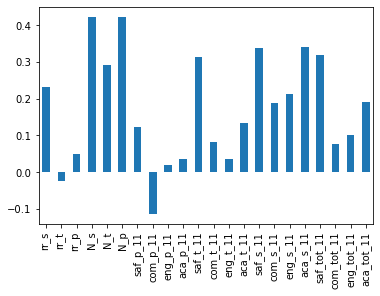

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

correlations[survey_fields].plot.bar()

plt.show()

We can find high correlations above 0.25 between N_s (number of student respondents), N_t (number of teacher respondents) and N_p (number of parent respondents) columns and the SAT score. These columns are related to the total enrollment.

saf_t_11, saf_s_11 and saf_tot_11, which measure how teachers and students perceive safety at school, correlated with sat_score. Safety environments will get a better score in SAT.

### Exploring Safety and SAT Scores

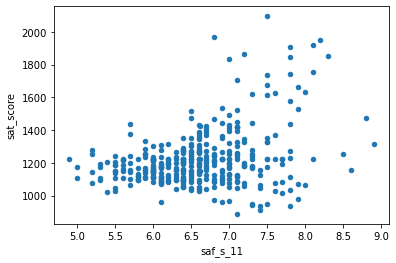

In [15]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

In [24]:
safe_boro = combined.groupby('boro')[['saf_s_11','saf_t_11','saf_tot_11']].agg(np.mean)
safe_boro

,saf_s_11,saf_t_11,saf_tot_11
boro,,,
Bronx,6.606577,7.026882,7.322581
Brooklyn,6.370755,6.985849,7.129245
Manhattan,6.831370,7.287778,7.473333
Queens,6.721875,7.365625,7.387500
Staten Island,6.530000,7.210000,7.200000


Students and teachers scores Manhattan and Queens as the safest boroughs and Brooklyn as the unsafest one.

### Exploring Race and SAT Scores

The columns `white_per`, `asian_per`, `black_per` and `hispanic_per` indicates the percentage of white/asian/black/hispanic students.

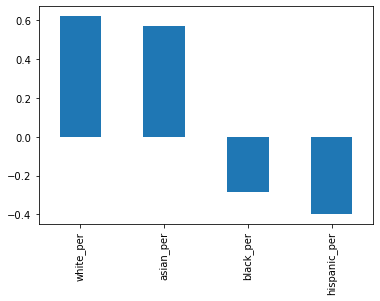

In [34]:
#racial_cols = combined.columns[combined.columns.str.contains('_per')]
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
racial_corr = combined.corr()['sat_score'][racial_cols]

racial_corr.plot.bar()
plt.show()

White and asian students have a better performance in SAT but it is not the case for black and hispanic students.

In [45]:
bool_mask = (combined['sat_score'] < 1000) & (combined['hispanic_per'] > 40)
lowSATschools_hisp = combined[bool_mask]

lowSATschools_hisp['SCHOOL NAME'].head()

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125      ACADEMY FOR LANGUAGE AND TECHNOLOGY
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
Name: SCHOOL NAME, dtype: object

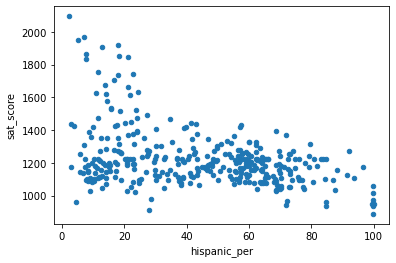

In [41]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

The greater is the percentage of hispanic students, the lower are the SAT scores.

In [47]:
bool_mask = combined['hispanic_per'] > 95
lowSATschools_hisp95 = combined[bool_mask]

lowSATschools_hisp95['SCHOOL NAME'].head()

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
Name: SCHOOL NAME, dtype: object

In [49]:
lowSATschools_hisp95[['SCHOOL NAME','ell_percent']].head()

,SCHOOL NAME,ell_percent
44,MANHATTAN BRIDGES HIGH SCHOOL,72.6
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,19.6
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,89.6
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,86.6
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,79.9


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English (mostly more than 70%), which would explain the lower SAT scores.

In [48]:
bool_mask = (combined['sat_score'] > 1800) & (combined['hispanic_per'] < 10)
highSATschools_nohisp = combined[bool_mask]

highSATschools_nohisp['SCHOOL NAME'].head()

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [50]:
highSATschools_nohisp[['SCHOOL NAME','ell_percent']].head()

,SCHOOL NAME,ell_percent
37,STUYVESANT HIGH SCHOOL,0.0
151,BRONX HIGH SCHOOL OF SCIENCE,0.1
187,BROOKLYN TECHNICAL HIGH SCHOOL,0.1
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,0.2
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,0.1


These schools have almost non English learners among their students. More of them are science schools which can ask for an entry exam making these students more performant than others.

### Exploring Gender and SAT Scores

The columns `male_per`and `female_per`indicates the percentage of male/female students.

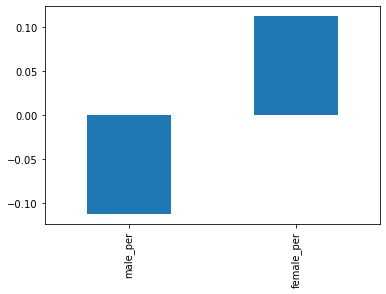

In [52]:
gender_corr = combined.corr()['sat_score'][['male_per','female_per']]

gender_corr.plot.bar()
plt.show()

Women have a better performance in SAT than men if we look to the correlation plot. It is a weak correlation for both.

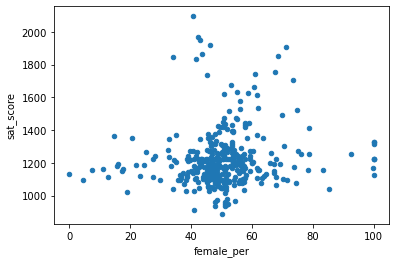

In [53]:
combined.plot.scatter(x='female_per',y='sat_score')
plt.show()

In [54]:
mask_bool = (combined['sat_score'] > 1700 ) & (combined['female_per'] > 60 )
fem_high_score = combined[mask_bool]

fem_high_score['SCHOOL NAME'].head()

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Exploring AP Scores and SAT Scores

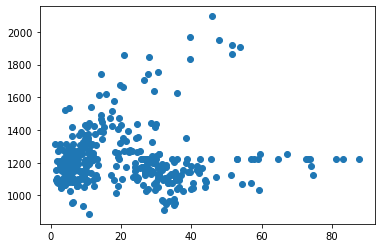

In [63]:
#ap_cols = combined.columns[combined.columns.str.contains('AP')] #AP Test Takers
ap_per = 100 * combined['AP Test Takers '] / combined['total_enrollment']
plt.scatter(x=ap_per, y=combined['sat_score'])
plt.show()

We cannot see a strong correlation between the percentage of AP test takers and the SAT score. Best marks in SAT are in schools with the 50% of students who take the AP test. But schools with more than 80% of students taking the AP test do not show a great performance in SAT tests.